# Lecture 11: Hypothesis Testing and Multiple Comparison Correction

## Goals
- **Neuroscience / Neuroimaging concepts**
    - Drawing scientific conclusions from contrast maps
- **Datascience / Coding concepts**
    - Hypothesis testing
    - Permutation Tests for significance
    - Multiple comparisons problem
    - Bonferroni correction

# Setup

Simply run the cells below that contain all the Python modules we'll neeed, plus setup matplotlib for plotting in this jupyter notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
from scipy.stats import zscore
import nibabel
import cortex
import os
from nistats.hemodynamic_models import glover_hrf as create_hrf
from sklearn.linear_model import LinearRegression

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, widgets, FloatSlider

np.random.seed(42)

# Set plotting defaults
%matplotlib inline

## Helper Functions

In [2]:
def load_nifti(filename, zscore=True, mask=None):
    img = nibabel.load(filename)
    data = img.get_data().T
    if mask is not None:
        data = data[:, mask]
    if zscore:
        data -= data.mean(0)
        data /= data.std(0) + 1e-8
    return data

In [3]:
def convolve_designmat(designmat):
    
    num_stim_types = designmat.shape[1]
    n = designmat.shape[0]

    # create the hrf
    hrf = create_hrf(tr=2, oversampling=1, time_length=32)
    
    # create the current shuffled design matrix using the shuffled indices
    cur_designmat = np.zeros(designmat.shape)
    for cur_column in np.arange(num_stim_types):
        cur_stim_vec_shuffled = designmat[:,cur_column]
        cur_designmat[:,cur_column] = np.convolve(cur_stim_vec_shuffled, hrf)[:n]        

    return cur_designmat

In [4]:
def create_fake_linear(n, a, b, noise_sd=None):
    x = np.random.randn(n)
    y = a * x + b
    if noise_sd is not None:
        y += np.random.randn(n)*noise_sd
    return (x,y)

# Review

Last week we covered how to analyze localizer data by calculating contrasts using multiple regression to find regions of interest (ROIs). The ROIs we found were qualitative, meaning we just looked at a map of the contrast values and determined approximately where the region is. After this review, we'll learn how to use hypothesis testing to quantitatively find ROIs.

## Load the visual localizer fMRI data

We'll start by loading the visual category localizer data that we've been using.

In [5]:
mask = cortex.db.get_mask('s01', 'catloc', 'cortical')

data01 = load_nifti("/data/cogneuro/fMRI/categories/s01_categories_01.nii.gz", zscore=True, mask=mask)
data02 = load_nifti("/data/cogneuro/fMRI/categories/s01_categories_02.nii.gz", zscore=True, mask=mask)
data03 = load_nifti("/data/cogneuro/fMRI/categories/s01_categories_03.nii.gz", zscore=True, mask=mask)

# Concatenate the data
data = np.concatenate((data01, data02, data03), axis=0)
data.shape

(360, 38543)

Now extract the data for a voxel in the FFA and PPA

In [6]:
FFA_Vox_Idx = 3464
PPA_Vox_Idx = 10433
data_faces = data[:, FFA_Vox_Idx]
data_places = data[:, PPA_Vox_Idx]

And pull out the number of categories in the data, and create a vector that represents time for the data as well.

In [7]:
n_TRs = data.shape[0]
time = np.arange(0,(n_TRs*2),2)
num_cortical_voxels = data.shape[1]

Load the category data

In [8]:
categories = np.load("/home/jovyan/catloc_experimental_conditions.npy")
unique_categories_no_nothing = np.unique(categories[categories != 'nothing'])

In [14]:
unique_categories_no_nothing

array(['body', 'faces', 'object', 'places', 'scrambled'], 
      dtype='<U9')

Simply create the stimulus design matrix here, since we'll need it, and not the response design matrix, to do permutation testing later on.

In [9]:
designmat_stimulus = np.zeros((len(categories), len(unique_categories_no_nothing)))
for i in np.arange(len(unique_categories_no_nothing)):
    designmat_stimulus[:,i] = (categories == unique_categories_no_nothing[i])

And we'll use a helper method to convolve the stimulus design matrix with an hrf to create the response design matrix.

In [10]:
designmat_response = convolve_designmat(designmat_stimulus)

## Multiple Regression

### Terminology: Estimator & Betas

An **estimator** is a mathematical formula that estimates some statistical paramater. In scikit-learn, the term estimator is used to describe the python objects that estimate model weights. So `LinearRegression` is an estimator.

We've used the terms **coefficient**, **weight** and **slope** interchangeably for the value of linear relationship between the independent and dependent variables in a simple linear regression. There is a 4th term often used in statistics, and that is **beta** or **beta weight**. We may use all 4 of these interchangeably.

### 2-D Independent vs. Dependent Variable Data
Last week we learned that we can fit a linear regression model that contains multiple independent variables (but one dependent variable) using the same `LinearRegression` estimator we used for simple linear regression. In order to estimate the beta weights we use in calculating the contrast maps that show the ROIs we need to fit a multiple regression model with all the stimulus categories that were shown during the experiment. 

The `LinearRegression` estimator can also be used to fit many models at the same time, which takes advantage of some linear algebra to be much more efficient that estimating each model separately. In the case of fMRI, we'll use this to estimate models for all the cortical voxels at the same time. It is important to be clear that a single multiple regression model can **ONLY** have multiple independent variables, and always a single dependent variable. We give the `fit` function of the `LinearRegression` estimator a 2-D matrix of dependent variable values because we want to estimate many models in parallel. Another way to say this is that giving `fit` a 1-D vector or 2-D matrix of independent variable data will both result in a single regression model being fit (simple vs. multiple regression). Giving `fit` a 1-D vector of dependent variable data will fit a single model, while giving it a 2-D matrix of dependent variable data will fit multiple models.

Let's fit many multiple regression models, one for each cortical voxel, to all the stimulus categories in our localizer experiment.

In [11]:
model_full = LinearRegression()
_ = model_full.fit(designmat_response, data)
weights = model_full.coef_

In [12]:
designmat_response.shape

(360, 5)

In [13]:
weights.shape

(38543, 5)

## Functional Localizers & Contrasts

Remember that functional localizers are experiments conducted alongside new studies to locate regions of interest (ROIs) that are well known. Locating well known ROIs allows new findings to be spatially situated relative to established findings. ROIs are found by calculating **contrasts**, which subtract the estimated brain activity in one condition from another, and are needed since the BOLD signal is a relatve measure of brain activity. Any given stimulus or task can invoke multiple cognitive processes, and it is important to design a contrast that isolates just the contrast you are interested in studying. While a simple rest condition can be appropriate in some scenarios (the motor localizer in your homeowork, for example), it is not always the appropriate contrast when multiple cognitive processes are evoked. 

The visual system consists of regions that are involved in *low-level* visual processing, which are involved in all visual processing, and higher-level regions that are selective to a specific stimulus type. Thus, to identify ROIs for those higher-level regions we must devise constrats that control for the low-level visual cognitive processes.

We defined the following contrasts last week which controlled for low-level visual processes:
1. **FFA**: faces - places
2. **PPA**: places - objects
3. **EBA**: bodies - objects
4. **LO**: objects - scrambled_objects

Let's review how to calculate these. Let's remind ourselves the order that the stimulus categories are in:

In [15]:
unique_categories_no_nothing

array(['body', 'faces', 'object', 'places', 'scrambled'], 
      dtype='<U9')

Now we'll define the indices of the 4 contrasts so we can use them later on:  

In [16]:
contrast_idxs_FFA = (1,3)
contrast_idxs_EBA = (0,2)
contrast_idxs_LO = (2,4)

Now we'll calculate these contrasts for all cortical voxels by using these indices on the weights we estimated with multiple regression above.

In [17]:
contrast_FFA = weights[:, contrast_idxs_FFA[0]] - weights[:, contrast_idxs_FFA[1]]
contrast_EBA = weights[:, contrast_idxs_EBA[0]] - weights[:, contrast_idxs_EBA[1]]
contrast_LO = weights[:, contrast_idxs_LO[0]] - weights[:, contrast_idxs_LO[1]]

We can thank make a Flatmap showing the value of each contrast to get a visual of where the ROI is.

There are a few arguments we can pass to the `cortex.Volume` function that make the visualization of the ROIs a bit easier to see. `cmap` tells pycortex which colormap to use. Remember that a colormap maps the values of the data being plotted to the colors used to represent those values. We'll use `cmap=Reds`, which makes the lowest values white, the largest dark red, and the middle values different shades of red. `vmin` tells pycortex what cortical value (in this case the contrast) should be assigned to the minimum value in the colormap (white in the `Reds` colormap). We'll use a value of `vmin=0`, which will have the effect of coloring all voxels where the places activity is greater than the faces activity as white.

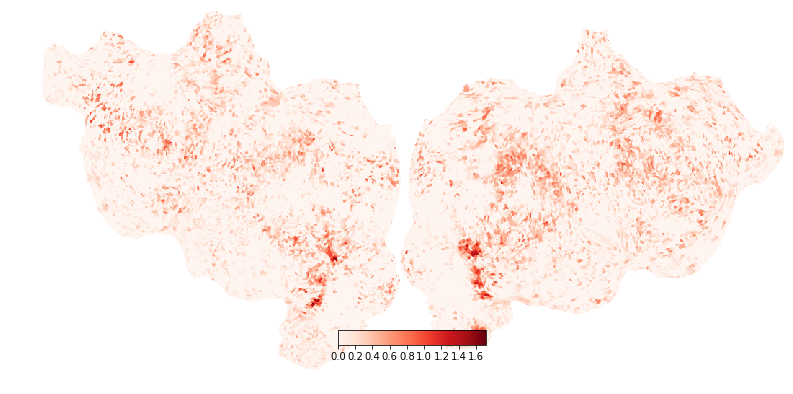

In [18]:
volume_contrast_FFA = cortex.Volume(contrast_FFA, 's01', 'catloc', vmin=0, cmap='Reds')
_ = cortex.quickshow(volume_contrast_FFA)

Let's plot the EBA contrast.

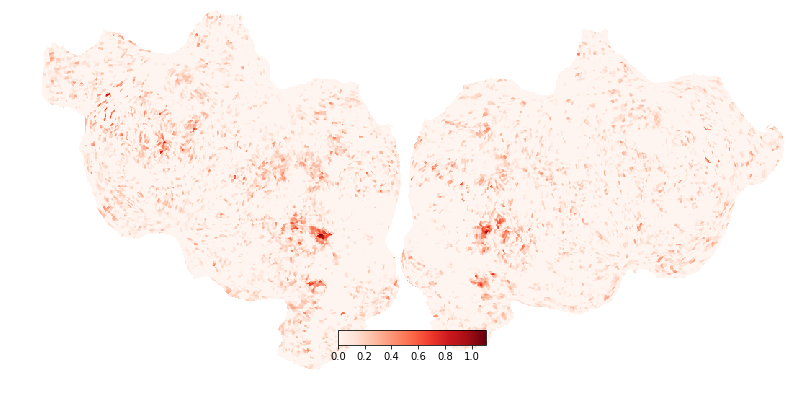

In [19]:
volume_contrast_EBA = cortex.Volume(contrast_EBA, 's01', 'catloc', vmin=0, cmap='Reds')
_ = cortex.quickshow(volume_contrast_EBA)

And the LO contrast.

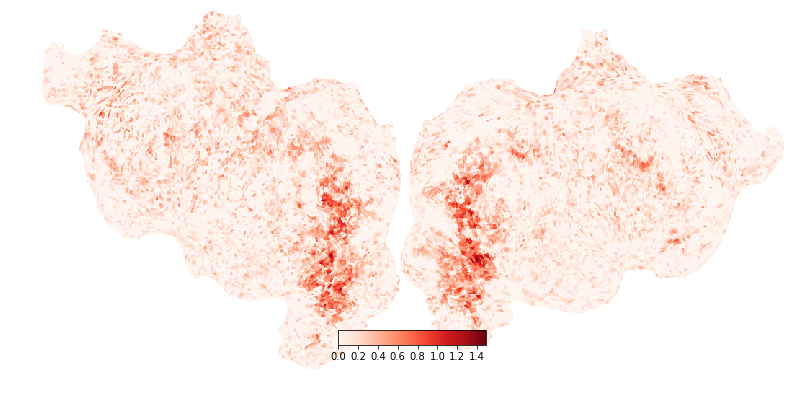

In [20]:
volume_contrast_LO = cortex.Volume(contrast_LO, 's01', 'catloc', vmin=0, cmap='Reds')
_ = cortex.quickshow(volume_contrast_LO)

#### Breakout Session

1\. Define the contrast indices for the PPA, and then calculate the contrast using those indices.

In [21]:
contrast_idxs_PPA = (3,2)
contrast_PPA = weights[:, contrast_idxs_PPA[0]] - weights[:, contrast_idxs_PPA[1]]

2\. Plot the flatmap showing the location of the PPA.

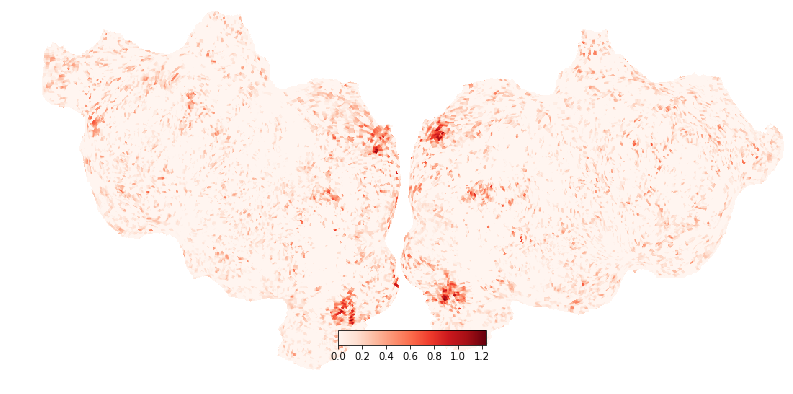

In [22]:
volume_contrast_PPA = cortex.Volume(contrast_PPA, 's01', 'catloc', vmin=0, cmap='Reds')
_ = cortex.quickshow(volume_contrast_PPA)

# Hypothesis Testing

Using linear regression we've seen how to estimate slopes that indicate the strength of the linear relationship between our independent variables (x) and our dependent variable (y). When this slope was positive in the above models, that meant that the BOLD signal increases everytime there is a stimulus of the given kind (e.g. faces) shown. We know there is a lot of noise in our data however, and so we need to know more than just whether the slope is positive, we need to account for the level of noise in the estimate of the slope. In other words, we want to know whether the slope is **significantly** greater than 0 (positive). **Hypothesis testing** is used a statistical technique that is used to determine **significance**.

In Data-8 you have learned about hypothesis testing. You learned that hypothesis testing is done by defining a **null hypothesis**, which defines what the distribution of results would look like under chance conditions, and an **alternative hypothesis** which indicates what the results would look like when something other than chance were at play. So for example, we could have an alternative hypothesis about our FFA contrast that it is greater than 0, and a null hypothesis that the contrast is 0 or smaller. 

A **test statistic** must then be chosen to quantify the results and choose which hypothesis is true. In this example, the contrast value would be the test statistic. 

Finally, we must define a distribution for the null hypothesis, and see how likely it is that the real result belongs to that **null distribution**.  There are several ways this can be done, and in most fMRI studies, so-called **Parametric Tests** are used to determine significance (e.g. a *t-test*). Since Data-8 does not cover these tests, we won't cover them here either, and instead we will use **Non-Parametric Tests** to account for the amount of noise in our estimates (by finding a null distribution), and determine significance. You have already covered one of thse, known as **the Boostrap Method** to estimate **confidence intervals**. Here we'll introduce a second techqniue known as **permutation testing**, compare and contrast it with the Bootsrap Method, and use it to determine significace of the contrasts we've estimated.

## Permutation Tests

A permutation test is done by randomly shuffling the values of the independent variables relative to the dependent variable. Another way to say that is it creates a null distribution where the observations are interchangeable, or the relationship between the dependent and independent variables is broken. It is a **resampling method**, just as the boostrap method, but it creates a null distribution instead of a distribution of samples for your statistic being estimated.

The boostrap method assumes that your sample is your population, and so **resamples with replacement** many times to simulate different samples from the same population. In permutation testing, the data is **resampled without replacement**, just in a new order. Let's lay out the steps of the perumtation test:

Let's create some fake data to show how permutation tests work. We'll determine if the slope from a linear regression of the fake data is significantly greater than 0 using the permutation test.

In [23]:
fake_n = 100
fake_slope = 1.2
fake_intercept = 3
fake_noise_sd = 0.4
fake_x, fake_y = create_fake_linear(fake_n, fake_slope, fake_intercept, fake_noise_sd)

And now let's calculate the estimated slope for this fake data

In [24]:
reg_fake = LinearRegression()
reg_fake.fit(fake_x.reshape(-1,1), fake_y.reshape(-1,1))
fake_slope_estimated = reg_fake.coef_[0,0]
fake_slope_estimated

1.1426971358914226

### Steps of Permutation Tests

1. Define the number of resamples you want to do (i.e. the size of your permuted null ditribution). Usually 1000 is big enough.
2. Create a vector to store the permuted null distribution.
3. Create a `for` loop that iterates over the number of resamples to take, and does the following in each iteration:

    a. Resample x with replacement by shuffling it's order

    b. Create the statistic you're interested in testing (in this case, the contrast between linear regression slopes) on the resampled x and original y data.
    
    c. Store that value in the vector you created in step #2.
    
4. Calculate the p-value: Determine how many values from the permuted null distribution are smaller than your actual value, which gives you a p-value. If the p-value is less than your $\alpha$ threshold, then reject the null hypothesis.

### Step 1: define the number of resamples to do

In [25]:
NUM_RESAMPLES = 1000

### Step 2: create the null distribution vector

In [27]:
null_dist_fake_slope = np.zeros((NUM_RESAMPLES))
null_dist_fake_slope.shape

(1000,)

### Step 3: loop and resample to create the null distribution

In [29]:
temp_indices = np.arange(10)
temp_indices

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
np.random.shuffle(temp_indices)
temp_indices

array([9, 1, 8, 7, 4, 2, 6, 3, 0, 5])

In [28]:
permute_indices = np.arange(fake_n)
reg_model_perm = LinearRegression()
for cur_iter in range(NUM_RESAMPLES):
    
    # Step 3a: resample x without replacement by shuffling the indices in x
    np.random.shuffle(permute_indices)
    fake_x_resample = fake_x[permute_indices]
    
    # Step 3b: fit the linear regression for the resampled data
    reg_model_perm.fit(fake_x_resample.reshape(-1, 1), fake_y.reshape(-1, 1))
    
    # Step 3c: store the slope in the null distribution vector
    null_dist_fake_slope[cur_iter] = reg_model_perm.coef_[0,0]

### Step 3 aside: Plot the null distribution

Now that we have a null distribution for the slope of the fake data, let's plot it! What type of plot should we use? The term null distribution gives us a clue. We know that a histogram is useful for plotting distributions in general, so it should also be the right plot to look at our null. Let's have a look.

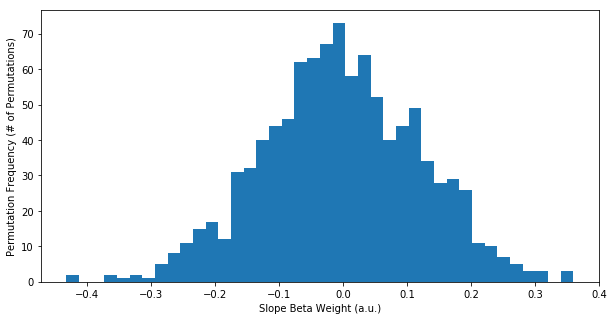

In [31]:
fig = plt.figure(figsize=(10,5))
plt.hist(null_dist_fake_slope, bins=40)
plt.xlabel('Slope Beta Weight (a.u.)')
_ = plt.ylabel('Permutation Frequency (# of Permutations)')

We want to know whether there is a significant slope between our fake data x and fake data y. The permutation test finds the null distribution for the hypothesis there is no relationship between fake x and fake y. Since we're using linear regression to find that relationship, the slope would be around 0 if there was no linear relationship. It looks like the mean of this null distribution is around 0, let's computer it exactly.

In [32]:
null_dist_fake_slope.mean()

-0.0032121440363681603

That's pretty close!

#### Step 4: Calculate the p-value to determine signifiance

To calculate significance we have to find the proportion of the values in the null distribution that are less than the real value of the slope, which gives us the p-value. Top do that we'll:
1. Find the number of values that are greater than the estimated slope. 
2. Divide the value from step #2 by the size of the null distribution to get the p-value

In [33]:
num_greater_null_fake = (null_dist_fake_slope > fake_slope_estimated).sum()
p_value_fake = num_greater_null_fake / NUM_RESAMPLES
p_value_fake

0.0

Hmmm, the p-value we calculated is 0, which means that the real value for the slope we estimated is greater than all the values in the null distribution. There's a problem with a p-value of `0` however. A probability of `0` means that there is absolutely no chance that null hypothesis is true, and there is always a *chance* that it is true, no matter how small. For this reason p-values are always greater than `0`, though they can be *very very very* small. (see this [paper](http://www.statsci.org/smyth/pubs/permp.pdf) for more details)

There is a correction for this problem (which also addresses a problem that the calculation we did above gives us a slightly higher error rate than we'd like). We simply add 1 to both the numerator and denominator. Let's have a look:

In [43]:
p_value_fake = (num_greater_null_fake + 1) / (NUM_RESAMPLES + 1)
p_value_fake

0.000999000999000999

That's a lot better, it gives us a very small, but non-zero, p-value.

#### Breakout Session

1\. Run the cell below to make some new fake data that has more noise. 

In [35]:
fake_noise_sd = 5
fake_x2, fake_y2 = create_fake_linear(fake_n, fake_slope, fake_intercept, fake_noise_sd)

In [27]:
null_dist_fake_slope = np.zeros((NUM_RESAMPLES))
null_dist_fake_slope.shape

(1000,)

2\. Redo the permutation analysis done above to calculate a p-value. Is this new data with more noise still significant?

In [36]:
null_dist_fake_slope2 = np.zeros((NUM_RESAMPLES))

In [37]:
permute_indices = np.arange(fake_n)
reg_model_perm = LinearRegression()
for cur_iter in range(NUM_RESAMPLES):
    
    # Step 3a: resample x without replacement by shuffling the indices in x
    np.random.shuffle(permute_indices)
    fake_x_resample2 = fake_x2[permute_indices]
    
    # Step 3b: fit the linear regression for the resampled data
    reg_model_perm.fit(fake_x_resample2.reshape(-1, 1), fake_y2.reshape(-1, 1))
    
    # Step 3c: store the slope in the null distribution vector
    null_dist_fake_slope2[cur_iter] = reg_model_perm.coef_[0,0]

In [44]:
reg_model_perm2 = LinearRegression()
reg_model_perm2.fit(fake_x2.reshape(-1, 1), fake_y2.reshape(-1, 1))
fake_slope_estimated2 = reg_model_perm2.coef_[0,0]
fake_slope_estimated2

1.8877117605892213

In [42]:
num_greater_null_fake2 = (null_dist_fake_slope2 > fake_slope_estimated2).sum()
p_value_fake2 = (num_greater_null_fake2+1) / (NUM_RESAMPLES+1)
p_value_fake2

0.001998001998001998

### Put the permutation test into a function

Let's put the permutation test into a function so we can use it with less code. Since a permutation test is a general tool that can be applied to any test statistic you would like, we need to be able to specify which test statistic to create in a general permutation test function. To do that we'll pass in a function as an argument to our permutation test function. This may seem strange, but functions are objects in python just as an int or a vector is, so we can use them in just the same way as arguments to functions. 

#### Functions as Arguments
Let's first create a function that we'll use as an argument:

In [45]:
def argument_function(x):
    print(x)

In [46]:
argument_function

<function __main__.argument_function>

Now let's create a function that takes some data and a function as arguments, and calls the argument function on the data:

In [53]:
def complex_function(x, func_arg):
    return func_arg(x)

Finally, let's call the `complex_function` passing in a number and the `argument_function`:

In [49]:
complex_function(5, argument_function)

5


In [51]:
abs

<function abs>

In [54]:
complex_function(-15, abs)

15

#### Create the Function
Now let's make the permutation test function. We'll specify two functions as arguments, one that shuffles the x data, and one that calculates the test_statistic (which can have an alternate parameter), as well as the x and y data and the number of resamples to do.

In [60]:
def permutation_test(x, y, shuffle_func, test_stat_func, 
                     test_stat_param=None, num_resamples=1000):
    n = x.shape[0]
    num_dependent = 1 if y.ndim == 1 else y.shape[1]
    null_dist = np.zeros((num_resamples,num_dependent))
    for cur_iter in range(num_resamples):

        # resample x without replacement by shuffling the indices in x using a function
        x_shuffle = shuffle_func(x)

        # calculate the test statistic using the function passed in
        if test_stat_param is None:
            test_stat = test_stat_func(x_shuffle,y)
        else:
            test_stat = test_stat_func(x_shuffle,y,test_stat_param)
            
        # store the test statistic in the null distribution vector
        null_dist[cur_iter,:] = test_stat
        
    # calculate the real test statistic for the x and y data, passing in the test_stat
    # param if one was passed in
    if test_stat_param is None:
        real_test_stat = test_stat_func(x,y)
    else:
        real_test_stat = test_stat_func(x,y,test_stat_param)
    
    # calculate the p-value
    num_greater_null = (null_dist > real_test_stat).sum(axis=0)
    p_value = (num_greater_null+1) / (num_resamples+1)
    
    # return the p-value and the null distribution
    return (p_value, null_dist, real_test_stat)

Let's use this function on the same fake data from the previous section to ensure it works. It won't give us the same exact null distribution, since it is random, but it should give us a very similar answer. We'll need to create a standard shuffle function that will simply shuffle the values in x.

In [56]:
def standard_shuffle(x):
    permute_indices = np.arange(x.shape[0])
    np.random.shuffle(permute_indices)
    return x[permute_indices]

We'll also need to define a function to calculate the test statistic, which in this case will fit a linear regression model and return the coefficient. Let's do that first.

In [57]:
def calc_slope(x,y):
    reg_model = LinearRegression()
    if x.ndim == 1:
        x = x.reshape(-1,1)
    if y.ndim == 1:
        y = y.reshape(-1,1)
    reg_model.fit(x,y)
    return reg_model.coef_[0,0]

Now we'll use this function, along with the x and y data to calculate a p-value.

In [61]:
p_value_fake2, null_dist_fake_slope2, fake_slope_estimated2 = permutation_test(fake_x, 
                                                                               fake_y, 
                                                                               standard_shuffle, 
                                                                               calc_slope)
p_value_fake2

array([ 0.000999])

Let's plot the null distribution, and this time we'll add a line that represents the real value of the test statistic, the slope in this case.

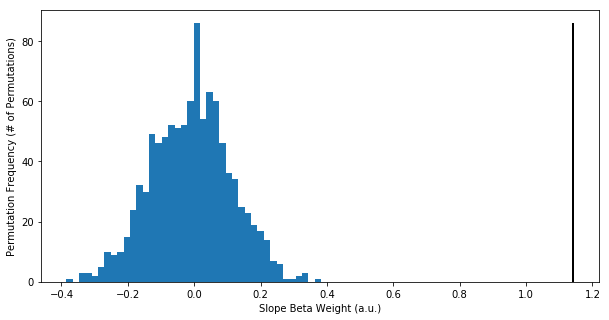

In [62]:
fig = plt.figure(figsize=(10,5))
hist_vals = plt.hist(null_dist_fake_slope2, bins=40)
plt.vlines(fake_slope_estimated2, 0, max(hist_vals[0]), lw=2)
plt.xlabel('Slope Beta Weight (a.u.)')
_ = plt.ylabel('Permutation Frequency (# of Permutations)')

#### Breakout Session

1\. Creating a function out of code requires a subtle skill, which is figuring out which values you need to pass into the function as arguments. Let's practice this by creating a function out of the code to plot the null distribution and the test statistic. Call the function `plot_nulldist`.

In [63]:
def plot_nulldist(null_dist, 
                  test_stat, 
                  num_bins=40, 
                  test_stat_name='Test Statistic', 
                  test_stat_units='a.u'):
    hist_vals = plt.hist(null_dist, bins=num_bins)
    plt.vlines(test_stat, 0, max(hist_vals[0]), lw=2)
    plt.xlabel('%s (%s)' % (test_stat_name, test_stat_units))
    _ = plt.ylabel('Permutation Frequency (# of Permutations)')

2\. Now use the function you just created to plot the null distribution and test statistic for the fake data just like was done above. Make sure you get the same plot!

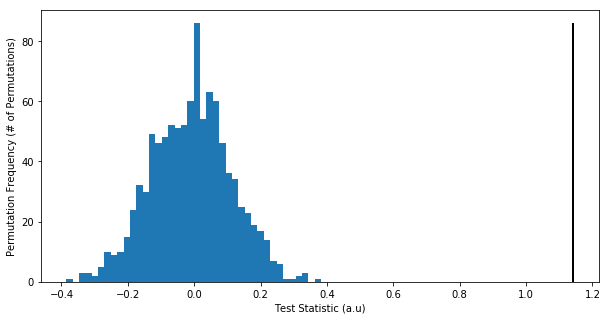

In [64]:
fig = plt.figure(figsize=(10,5))
plot_nulldist(null_dist_fake_slope2, fake_slope_estimated2, num_bins=40)

## Applying Permutation Tests to Real fMRI data

### Resampling with an HRF and Block Design

As we've learned permutation testing involves resampling our data without replacement. Since real fMRI data has an HRF convolved with the neural response, and the HRF spans multiple TRs, one burst of neural activity affects multiple TRs (or volumes). Another way to say this is that the value of one TR depends on the values of the previous TRs. Since an assumption of the permutation test method is that the observations are exchangeable, this dependence from the HRF means we cannot just randomly shuffle the design matrix. To resolve this, we will shuffle the stimulus (and not response!) design matrix, and then convolve this new design matrix with the HRF.

We also now something about the structure of this localizer data, namely that the stimuli were presented in blocks. We should take this into account when creating our null distribution, since we want it to reflect randomizing the stimlus types, and not changing the design of the experiment from a block design to an event-related design (which is what would happen if we shuffled all the trials and not the blocks). So we'll shuffle the blocks together.

Let's see how we can shuffle blocks of the stimulus design matrix and convolve instead of just shuffling the x. First we need to determine the block size. To do that we'll just look at the entries in the `categories` vector and just count how many stimuli were presented in a given block. We'll assume that each block is the same size, since we happen to know that is how the experiment was designed.

In [65]:
categories[:50]

array(['faces', 'faces', 'faces', 'faces', 'faces', 'faces', 'faces',
       'faces', 'faces', 'faces', 'object', 'object', 'object', 'object',
       'object', 'object', 'object', 'object', 'object', 'object', 'body',
       'body', 'body', 'body', 'body', 'body', 'body', 'body', 'body',
       'body', 'scrambled', 'scrambled', 'scrambled', 'scrambled',
       'scrambled', 'scrambled', 'scrambled', 'scrambled', 'scrambled',
       'scrambled', 'places', 'places', 'places', 'places', 'places',
       'places', 'places', 'places', 'places', 'places'], 
      dtype='<U9')

There are 10 stimuli in each block. Let's set that value into a name and determine how many blocks we'll need by dividing the length of the localizer data by the block size.

In [67]:
block_size = 10
n_blocks = int(n_TRs/block_size)
n_blocks

36

Now we're going to create an array that contains all the indices of the design matrix rows. Then we're going to use some numpy trickery to shuffle the indices in blocks. We'll reshape the 1-D vector of indices into a 2-D matrix with the number of columns equal to the block size and the number of rows equal to the number of blocks. Thus each row represents the indices for a single block, and we can then shuffle the rows, which will in essences shuffle blocks. We'll use the same `np.random.shuffle` since it always shuffles along the first axis of an N-D array, which is exactly what we want.

In [68]:
indices = np.arange(n_TRs)
blocked_indices = indices.reshape([n_blocks,block_size])
np.random.shuffle(blocked_indices)
blocked_indices

array([[ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
       [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39],
       [330, 331, 332, 333, 334, 335, 336, 337, 338, 339],
       [230, 231, 232, 233, 234, 235, 236, 237, 238, 239],
       [ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
       [250, 251, 252, 253, 254, 255, 256, 257, 258, 259],
       [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
       [170, 171, 172, 173, 174, 175, 176, 177, 178, 179],
       [190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
       [340, 341, 342, 343, 344, 345, 346, 347, 348, 349],
       [260, 261, 262, 263, 264, 265, 266, 267, 268, 269],
       [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
       [270, 271, 272, 273, 274, 275, 276, 277, 278, 279],
       [240, 241, 242, 243, 244, 245, 246, 247, 248, 249],
       [200, 201, 202, 203, 204, 205, 206, 207, 208, 209],
       [320, 321, 322, 323, 324, 325, 326, 327, 328, 329],
       [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99

Finally, we'll reshape the 2-D matrix of block indices into a 1-D vector that we can use on the stimulus design matrix.

In [69]:
indices_block_shuffled = blocked_indices.reshape([-1])    
indices_block_shuffled.shape

(360,)

Let's put these steps together to create a function that will shuffle a design matrix by blocks. We'll hard code the block size as 10 here.

In [70]:
def shuffle_blocks(x):
    block_size = 10
    n = x.shape[0]
    n_blocks = int(n/block_size)        

    # shuffle the indices by blocks
    indices = np.arange(n)
    blocked_indices = indices.reshape([n_blocks,block_size])
    np.random.shuffle(blocked_indices)
    indices_block_shuffled = blocked_indices.reshape([-1])    
    x_block_shuffled = x[indices_block_shuffled,:]

    return x_block_shuffled

#### Breakout Session

1\. Use the `shuffle_blocks` function we just created on the stimulus design matrix `designmat_stimulus` for the visual localizer data. 

In [74]:
designmat_stim_shuffled = shuffle_blocks(designmat_stimulus)

2\. Plot the shuffled design matrix as an image. Did the function work? How can you tell?

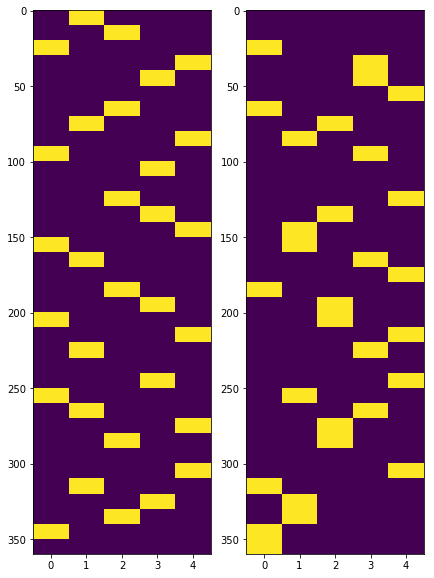

In [75]:
fig = plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
plt.imshow(designmat_stimulus, aspect='auto')
plt.subplot(1,2,2)
plt.imshow(designmat_stim_shuffled, aspect='auto')

### Contrast Permutation Tests 

Now that we have the correct function to resample, let's do a permutation test on our faces - places contrast to get p-values.

First we'll define a function that calculates the test-statistic, in this case the contrast we're intrested in.

In [71]:
def calc_contrast_convolve(designmat, bold_data, contrast_idxs):
    # convolve the stimulus design matrix with the hrf and return it
    designmat_conv = convolve_designmat(designmat)
    
    # fit the model on the convolved design matrix
    model = LinearRegression()
    model.fit(designmat_conv, bold_data)
    contrast = model.coef_[:, contrast_idxs[0]] - model.coef_[:, contrast_idxs[1]]
    return contrast

Now we'll use the new shuffle block and create contrast functions to do the permutation test on our real fMRI data to create p-values for our contrast.

In [72]:
(contrast_FFA_pvalue, null_dists_contrast_FFA, contrast_FFA) = permutation_test(designmat_stimulus, 
                                                                                data, 
                                                                                shuffle_blocks, 
                                                                                calc_contrast_convolve, 
                                                                                contrast_idxs_FFA, 
                                                                                100)

Let's plot a couple voxels' null distributions along with their contrast value. We'll do one in the FFA and one in the PPA.

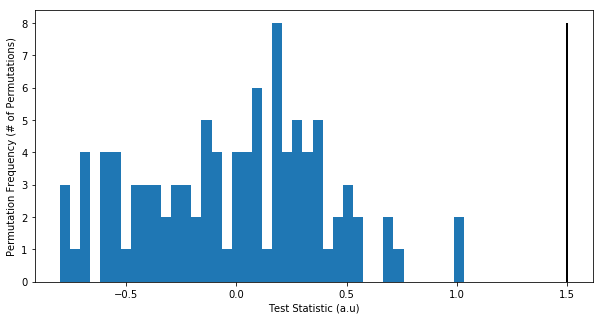

In [76]:
fig = plt.figure(figsize=(10,5))
plot_nulldist(null_dists_contrast_FFA[:,FFA_Vox_Idx], contrast_FFA[FFA_Vox_Idx], num_bins=40)

As we'd expect the actual faces - places contrast value is much higher for the FFA voxel.

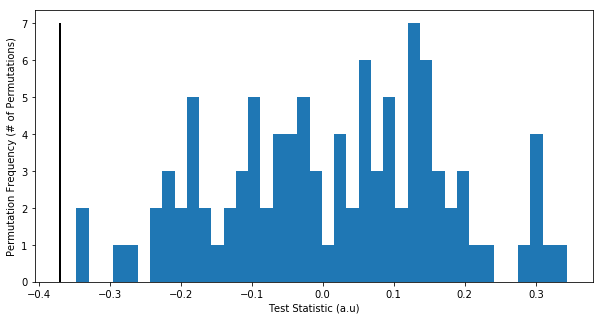

In [77]:
fig = plt.figure(figsize=(10,5))
plot_nulldist(null_dists_contrast_FFA[:,PPA_Vox_Idx], contrast_FFA[PPA_Vox_Idx], num_bins=40)

And much lower for the PPA voxel!

#### Breakout Session

1\. Do a permutation test of the PPA contrast on all cortical voxels. Use the same `permutation_test` function as above. 

### Contrast Flatmaps with Significant Voxels

We can plot the p-values calculated using permutation tests to get an idea of where the contrasts are significantly greater than 0. Since a smaller p-value means it is **MORE** significant, it's useful to transform the data by first inverting it so that big is small and small is big. Then we can apply a log transoformation, which will spread out the values close to 0 so that we can differentiate between small values, which is where the threhsold significance lies. 

In [78]:
contrast_FFA_pvalue.shape

(38543,)

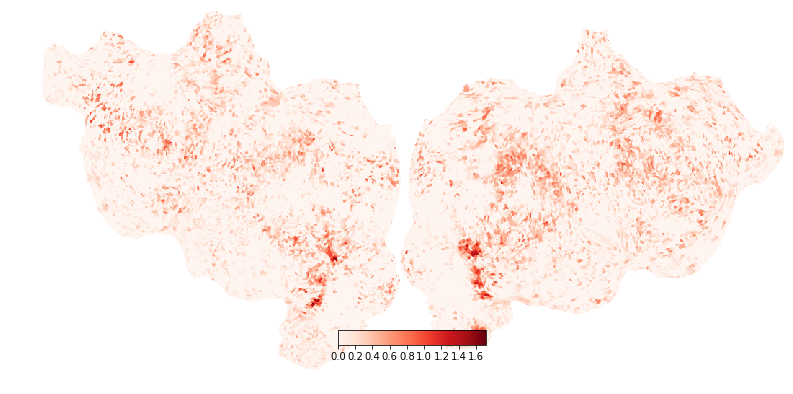

In [79]:
volume_contrast_FFA = cortex.Volume(contrast_FFA, 's01', 'catloc', vmin=0, cmap='Reds')
_ = cortex.quickshow(volume_contrast_FFA)

In [ ]:
contrast_FFA_pvalue[FFA_Vox_Idx]

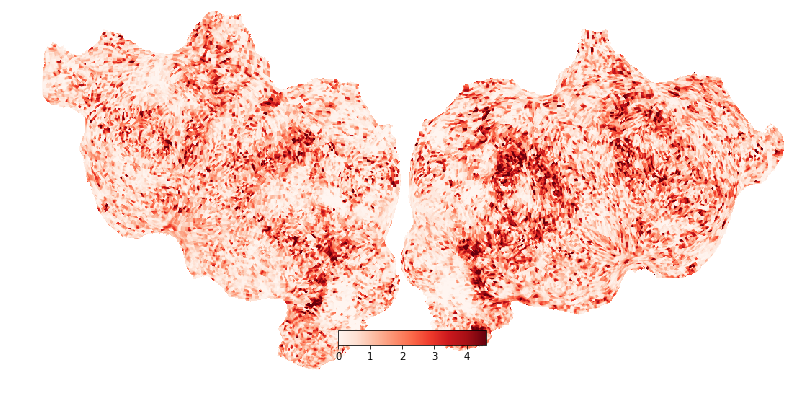

In [80]:
contrast_FFA_pvalue_volume = cortex.Volume(-np.log(contrast_FFA_pvalue), subject='s01', xfmname='catloc', cmap='Reds')
_ = cortex.quickshow(contrast_FFA_pvalue_volume)

We can also threshold the p-values to create a simple mask that indicates which voxels have a significant contrast or not. 

In [81]:
alpha = .05
contrast_FFA_sig = contrast_FFA_pvalue < alpha

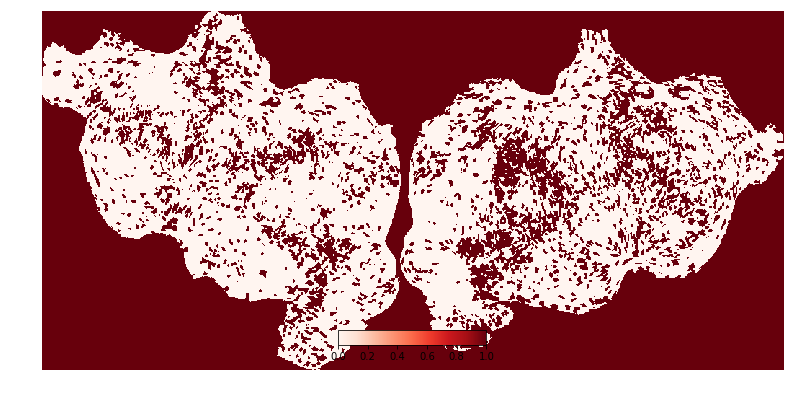

In [82]:
volume_contrast_FFA_sig = cortex.Volume(contrast_FFA_sig, 's01', 'catloc', cmap='Reds', vmin=0, vmax=1)
_ = cortex.quickshow(volume_contrast_FFA_sig)

#### Breakout Session

1\. Create a mask of the significant voxels for the PPA contrast and plot it on a flatmap.

# Multiple Comparison Correction

### What is a p-value again?

A p-value tells us the probability that our test statistic comes from the null distribution. That means when we reject the null hypothesis with an $\alpha$`=.05`,  5% of the time the real value is 0 (or whatever the null hypothesis is). That's acceptable if we are only calculating 1 p-value, but if we have 100 p-values that we are calculating, and they are all truly not significant, we'll still find 5 that "look" significant. Here's a comic that uses this idea for it's punchline:

<img src='figures/significant.png' style=''>

We need to correct for this, and this correction is called a mutliple comparisons correction. There are many ways to do this comparison, some of which are more sensitive than others. The most common methos used in fMRI fall into one of two categories: **Family Wise Error** correction and the **False Discovery Rate**. The most basic correction that can be done is called a Bonferroni correction, and is a type of **Family Wise Error** correction. Let's explore that now...

### The dead salmon study: Why we do multiple comparisons correction

An influential study by Bennett et al. (2010) showed that a group of voxels in a dead salmon were implicated in processing social cues from images. Seeing as how the fish was *DEAD*, these findings were clearly some **false positives**, i.e., an effect that is marked as real or significant even though it really was not. This study was designed to show the perils of failing to correct for multiple comparisons.

<img src='figures/dead-salmon-fmri1.png'>

Here are some good blog posts about this study:
http://neuroskeptic.blogspot.com/2009/09/fmri-gets-slap-in-face-with-dead-fish.html
https://blogs.scientificamerican.com/scicurious-brain/ignobel-prize-in-neuroscience-the-dead-salmon-study/

The orinigal study:

Bennett et al. "Neural Correlates of Interspecies Perspective Taking in the Post-Mortem Atlantic Salmon: An Argument For Proper Multiple Comparisons Correction" Journal of Serendipitous and Unexpected Results, 2010

### Bonferroni Correction: Adjusting the alpha level

If multiple hypotheses are tested, the chance of a rare event increases, and therefore, the likelihood of incorrectly rejecting a null hypothesis (i.e., making a Type I error) increases. The Bonferroni correction compensates for that increase by testing each individual hypothesis at a significance level of `alpha/m`, where alpha is the desired overall alpha level and m is the number of hypotheses. For example, if a trial is testing `m=20` hypotheses with a desired `alpha = 0.05`, then the Bonferroni correction would test each individual hypothesis at `alpha =0.05/20=0.0025`.

from: https://en.wikipedia.org/wiki/Bonferroni_correction

Let's use the Bonferroni correction to adjust the alpha level for all cortical voxels.

In [ ]:
alpha_adjusted = alpha/num_cortical_voxels
alpha_adjusted

Now we can use this adjusted p-value to determine significance. Let's recreate a map that uses this value.

In [ ]:
contrast_FFA_sig_Bon = contrast_FFA_pvalue < alpha_adjusted

In [ ]:
volume_contrast_FFA_sig_Bon = cortex.Volume(contrast_FFA_sig_Bon, 's01', 'catloc', cmap='Reds', vmin=0, vmax=1)
_ = cortex.quickshow(volume_contrast_FFA_sig_Bon)

Huh, nothing is significant! This is not the truth, rather a side-effect of the permutation test we did. We'll learn more next week!